In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
Categories = ['cats', 'dogs']
hog_data_arr = [] # Mảng chứa đặc trưng HOG
target_arr = []    # Mảng chứa nhãn
datadir = 'training_set' 

# --- CẤU HÌNH CHO HOG ---
# Resize về 128x64 hoặc 128x128 là chuẩn nhất cho HOG (vì chia hết cho 8)
IMG_HEIGHT = 128
IMG_WIDTH = 128

for i in Categories:
    print(f'Đang xử lý danh mục: {i}...')
    path = os.path.join(datadir, i)
    
    for img_name in os.listdir(path):
        # 1. Đọc ảnh
        img_array = imread(os.path.join(path, img_name))
            
        # 2. Resize ảnh
        # Chúng ta dùng 128x128 để chia hết cho pixels_per_cell (8)
        img_resized = resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
            
        # 3. Tính toán đặc trưng HOG
        # channel_axis=-1 báo cho hàm biết đây là ảnh màu (chiều cuối là kênh màu)
        # pixels_per_cell=(8, 8): Chia ảnh thành các ô 8x8 pixel
        # cells_per_block=(2, 2): Gom 2x2 ô thành một khối để chuẩn hóa
        fd, hog_image = hog(img_resized, 
                            orientations=9, 
                            pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2), 
                            visualize=True, 
                            channel_axis=-1)
                                
        # 'fd' (feature descriptor) chính là vector đặc trưng đã rút gọn
        hog_data_arr.append(fd)
        target_arr.append(Categories.index(i))
        
    print(f'Hoàn tất danh mục: {i}')

# Chuyển đổi sang NumPy array
hog_data = np.array(hog_data_arr)
target = np.array(target_arr)

Đang xử lý danh mục: cats...
Hoàn tất danh mục: cats
Đang xử lý danh mục: dogs...
Hoàn tất danh mục: dogs


In [3]:
#dataframe
df = pd.DataFrame(hog_data)
df['Target'] = target
df.shape

(1001, 8101)

In [4]:
#input data
x = df.iloc[:, :-1]
#output data
y = df.iloc[:, -1]

In [5]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20,
                                                    random_state = 77,
                                                    stratify = y)

In [6]:
# Pipeline: chuẩn hóa dữ liệu → phân loại bằng SVM (RBF)
# probability=True để xuất xác suất dự đoán
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True))
])

# Thiết lập không gian tìm kiếm tham số cho SVM
# C: mức độ phạt sai số (nhỏ → tổng quát tốt hơn, lớn → dễ overfitting)
# gamma: phạm vi ảnh hưởng của mỗi điểm dữ liệu (nhỏ → mượt, lớn → biên phức tạp)
# class_weight: cân bằng dữ liệu khi các lớp không đều
param_dist = {
    'svc__C': loguniform(1e1, 1e3),
    'svc__gamma': loguniform(1e-4, 1e-2),
    'svc__class_weight': [None, 'balanced']
}

# RandomizedSearchCV: tìm bộ tham số tốt nhất bằng lấy mẫu ngẫu nhiên
model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


In [7]:
# Huấn luyện mô hình bằng dữ liệu huấn luyện
model.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018E43044C70>,
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018E4FC61730>},
                   random_state=42, scoring='accuracy')

In [8]:
print("Best params:", model.best_params_)
print("Best score:", model.best_score_)

Best params: {'svc__C': np.float64(362.5617634576225), 'svc__class_weight': None, 'svc__gamma': np.float64(0.0002051338263087451)}
Best score: 0.7350000000000001


In [9]:
# Lưu mô hình vào file có tên 'model_cho_meo.pkl'
joblib.dump(model, 'model_cho_meo.pkl')

print("Đã lưu mô hình thành công!")

Đã lưu mô hình thành công!


In [10]:
# Kiểm thử mô hình sử dụng dữ liệu kiểm tra
y_pred = model.predict(x_test)

# Tính toán độ chính xác của mô hình
accuracy = accuracy_score(y_pred, y_test)

# In ra độ chính xác của mô hình
print(f"The model is {accuracy*100}% accurate")

The model is 72.636815920398% accurate


In [11]:
print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.74      0.70      0.72       100
         dog       0.72      0.75      0.73       101

    accuracy                           0.73       201
   macro avg       0.73      0.73      0.73       201
weighted avg       0.73      0.73      0.73       201



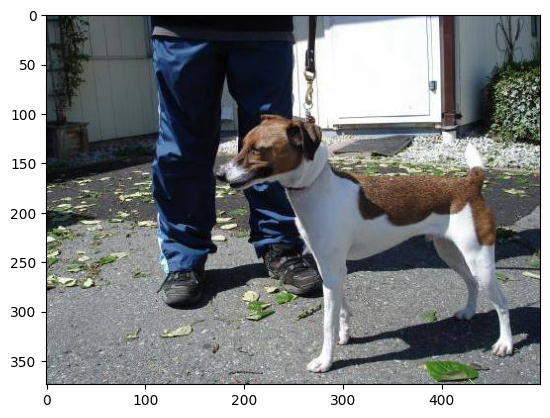

cats = 88.31986636943697%
dogs = 11.680133630562999%
The predicted image is: cats


In [12]:
path = 'test_set/dogs/dog.4023.jpg'

img = imread(path)
plt.imshow(img)
plt.show()

img_resized = resize(img,(128,128))

fd, _ = hog(img_resized, 
                orientations=9, 
                pixels_per_cell=(8, 8), 
                cells_per_block=(2, 2), 
                visualize=True, 
                channel_axis=-1)

l = [fd]

probability = model.predict_proba(l)

for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is: " + Categories[model.predict(l)[0]])